# Предсказание стоимости жилья в Мельбурне с помощью ML

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
df = pd.read_csv('/content/melb_data.csv')

In [134]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [135]:
df = df.drop(['Address', 'Method', 'SellerG', 'Date', 'Postcode', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount'], axis = 1)

In [136]:
print(df.isnull().sum().sort_values(ascending=False))

BuildingArea    6450
YearBuilt       5375
CouncilArea     1369
Car               62
Price              0
Type               0
Rooms              0
Suburb             0
Bathroom           0
Bedroom2           0
Distance           0
Landsize           0
dtype: int64


In [137]:
df['Car'].fillna(df['Car'].median(), inplace=True)
df['BuildingArea'].fillna(df['BuildingArea'].median(), inplace=True)
df['YearBuilt'].fillna(df['YearBuilt'].median(), inplace=True)
df['CouncilArea'].fillna('Unknown', inplace=True)
df['Bathroom'].fillna(df['Bathroom'].median(), inplace=True)

/tmp/ipython-input-702484300.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Car'].fillna(df['Car'].median(), inplace=True)
/tmp/ipython-input-702484300.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

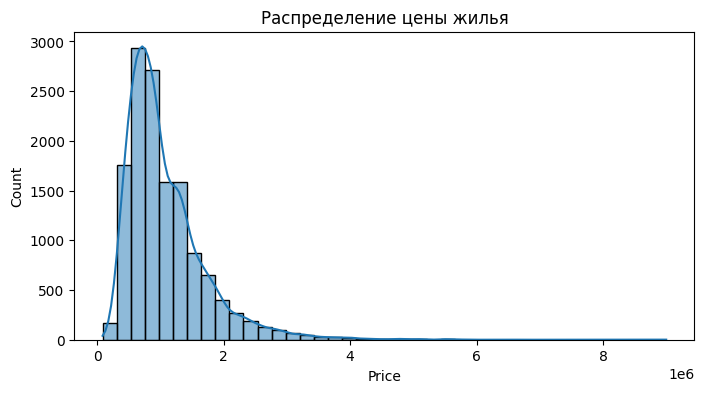

In [138]:
plt.figure(figsize=(8,4))
sns.histplot(df['Price'], bins=40, kde=True)
plt.title('Распределение цены жилья')
plt.show()

Чистка от выбросов

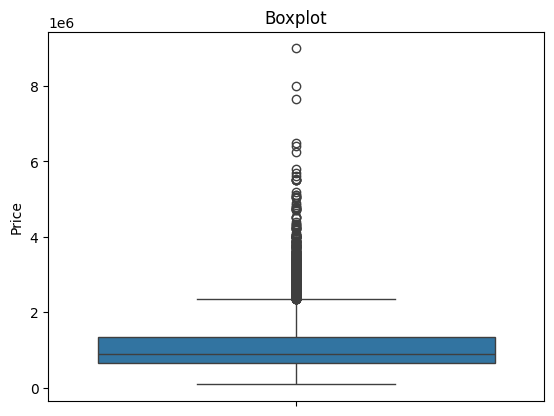

In [139]:
sns.boxplot(df['Price'])
plt.title("Boxplot")
plt.show()

In [140]:
def remove_outliers(df, cols, lower_quantile=0.01, upper_quantile=0.99):
    df_clean = df.copy()
    for col in cols:
        low = df_clean[col].quantile(lower_quantile)
        high = df_clean[col].quantile(upper_quantile)
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]
    return df_clean

In [141]:
df_clean = remove_outliers(df, ['Price', 'Landsize', 'BuildingArea', 'Distance'])
print("До очистки:", df.shape)
print("После очистки:", df_clean.shape)

До очистки: (13580, 12)
После очистки: (12729, 12)


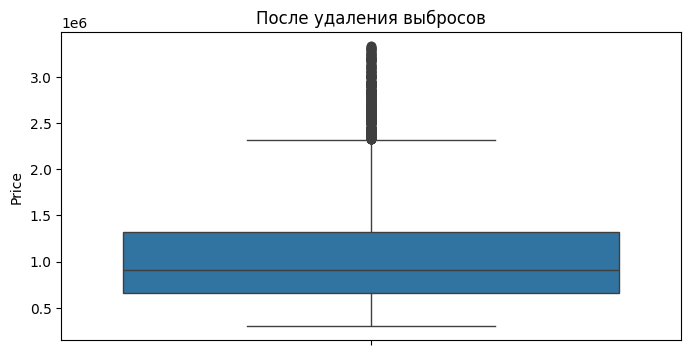

In [142]:
plt.figure(figsize=(8,4))
sns.boxplot(df_clean['Price'])
plt.title("После удаления выбросов")
plt.show()

In [143]:
X = df_clean.drop('Price', axis = 1)
y = df_clean['Price']

In [144]:
X_cat = pd.get_dummies(X, columns = ['Suburb', 'CouncilArea', 'Type'])

In [145]:
num_cols = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']

In [146]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = X_cat.copy()
X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])

In [147]:
print(X_scaled[num_cols].head())
print(X_scaled.shape)

      Rooms  Distance  Bedroom2  Bathroom       Car  Landsize  BuildingArea  \
0 -1.015517 -1.444881 -0.976242 -0.779453 -0.636010 -0.679522     -0.145434   
1 -1.015517 -1.444881 -0.976242 -0.779453 -1.689323 -0.812935     -1.205732   
2  0.067650 -1.444881  0.092160  0.740176 -1.689323 -0.876742      0.395994   
3  0.067650 -1.444881  0.092160  0.740176 -0.636010 -0.992754     -0.145434   
4  1.150817 -1.444881  0.092160 -0.779453  0.417304 -0.917346      0.215518   

   YearBuilt  
0   0.127584  
1  -2.282396  
2  -2.282396  
3   0.127584  
4   1.642429  
(12729, 323)


 Linear Regression

In [161]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', mae)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
print('RMSE:', rmse)

MAE: 203354.01987341157
RMSE: 279162.00236686144


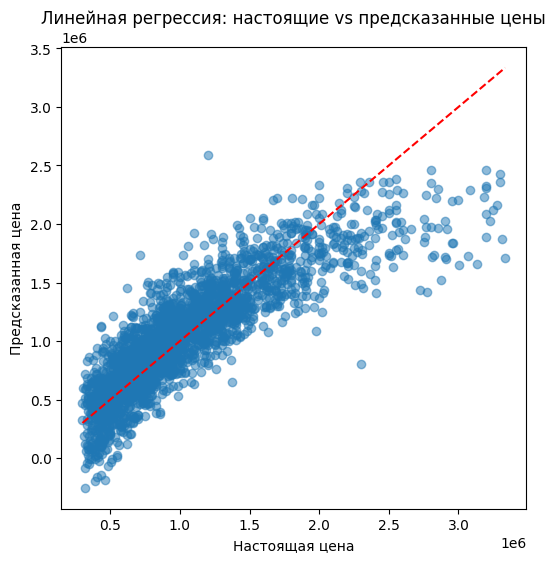

In [149]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Настоящая цена")
plt.ylabel("Предсказанная цена")
plt.title("Линейная регрессия: настоящие vs предсказанные цены")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Decision Tree

In [150]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    random_state=42
)

tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

mae_tree = mean_absolute_error(y_test, y_pred_tree)
rmse_tree = mean_squared_error(y_test, y_pred_tree) ** 0.5

print(f"Decision Tree -> MAE: {mae_tree:.2f}, RMSE: {rmse_tree:.2f}")

Decision Tree -> MAE: 221161.46, RMSE: 316452.00


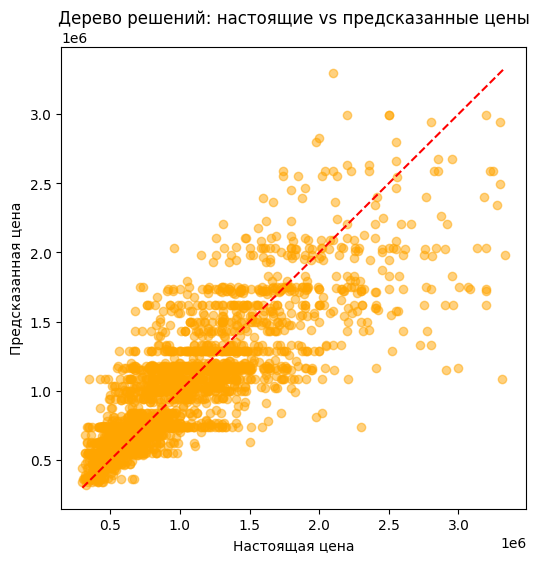

In [151]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_tree, alpha=0.5, color='orange')
plt.xlabel("Настоящая цена")
plt.ylabel("Предсказанная цена")
plt.title("Дерево решений: настоящие vs предсказанные цены")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

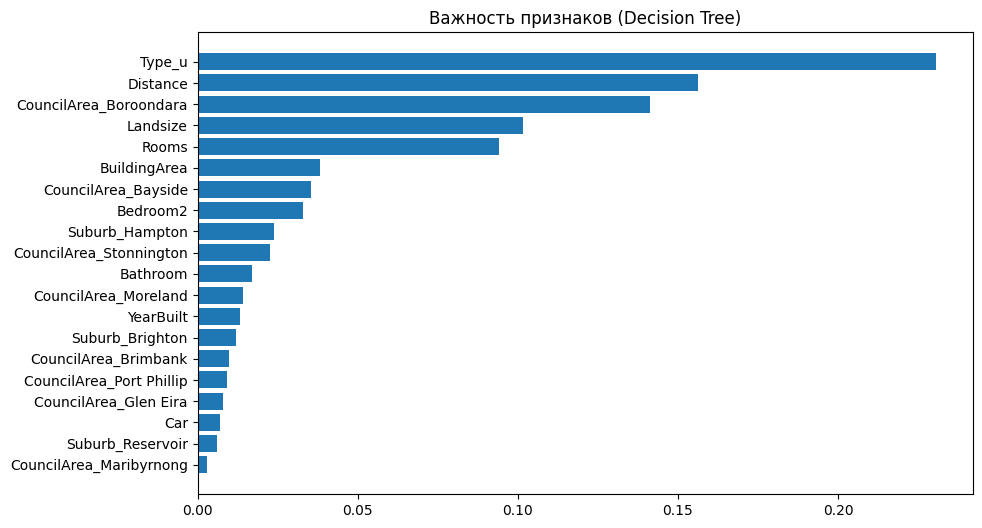

In [152]:
feature_importance = pd.DataFrame({
    'feature': X_scaled.columns,
    'importance': tree.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.title("Важность признаков (Decision Tree)")
plt.gca().invert_yaxis()
plt.show()

Random Forest

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

print(f"Random Forest -> MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")

Random Forest -> MAE: 170831.94, RMSE: 249069.77


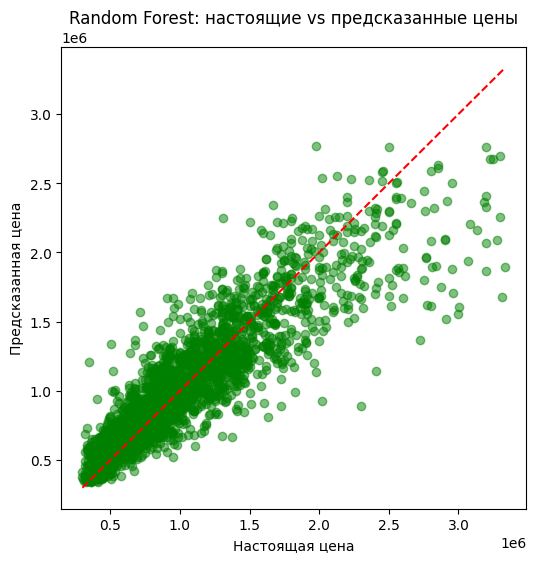

In [154]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
plt.xlabel("Настоящая цена")
plt.ylabel("Предсказанная цена")
plt.title("Random Forest: настоящие vs предсказанные цены")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Gradient Boosting

In [155]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr) ** 0.5

print(f"Gradient Boosting -> MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}")

Gradient Boosting -> MAE: 165525.41, RMSE: 241377.70


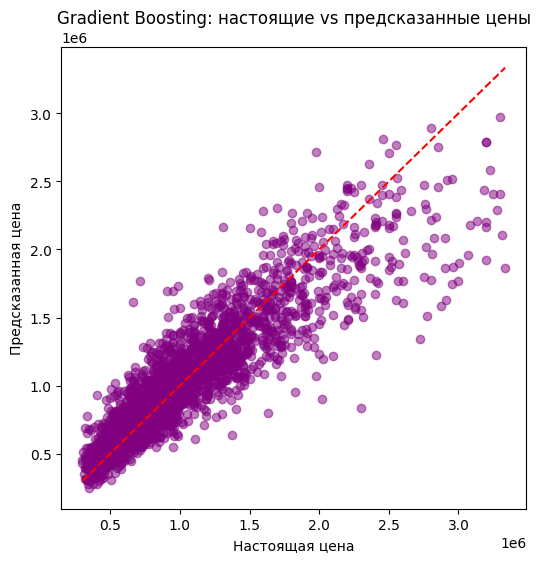

In [157]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_gbr, alpha=0.5, color='purple')
plt.xlabel("Настоящая цена")
plt.ylabel("Предсказанная цена")
plt.title("Gradient Boosting: настоящие vs предсказанные цены")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

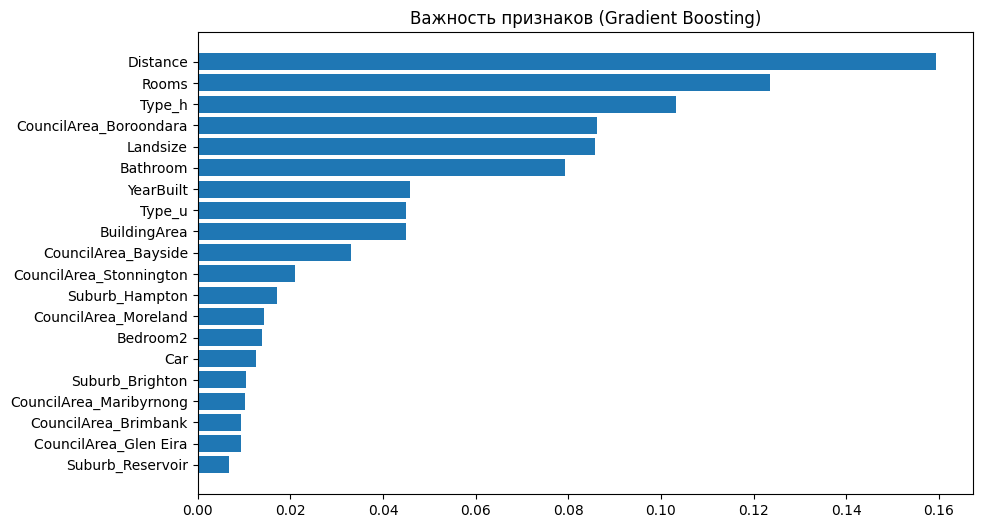

In [156]:
feature_importance_gbr = pd.DataFrame({
    'feature': X_scaled.columns,
    'importance': gbr.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance_gbr['feature'][:20], feature_importance_gbr['importance'][:20])
plt.title("Важность признаков (Gradient Boosting)")
plt.gca().invert_yaxis()
plt.show()

In [158]:
!pip install xgboost
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5

print(f"XGBoost -> MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

XGBoost -> MAE: 153698.48, RMSE: 226802.97


               Model            MAE           RMSE
0  Linear Regression  203354.019873  279162.002367
1      Decision Tree  221161.457783  316451.996835
2      Random Forest  170831.939341  249069.770034
3  Gradient Boosting  165525.405728  241377.699316
4            XGBoost  153698.476532  226802.965981


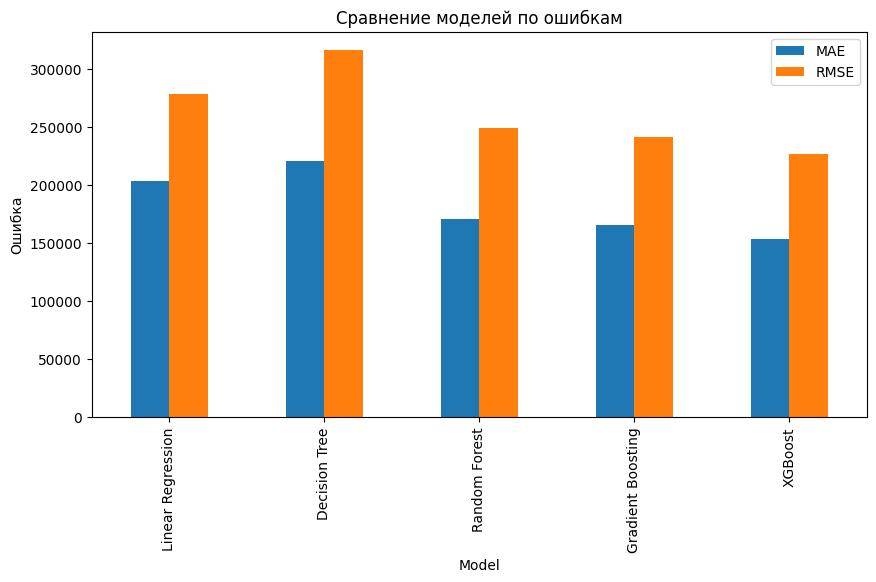

In [162]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MAE': [mae, mae_tree, mae_rf, mae_gbr, mae_xgb],
    'RMSE': [rmse, rmse_tree, rmse_rf, rmse_gbr, rmse_xgb]
})

print(results)

results.plot(x='Model', y=['MAE', 'RMSE'], kind='bar', figsize=(10,5))
plt.title("Сравнение моделей по ошибкам")
plt.ylabel("Ошибка")
plt.show()